<a href="https://colab.research.google.com/github/AwaisAli37405/Deep_Learning_with_fast_ai/blob/master/Deep_Learning_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [68]:
# !pip install -U fastprogress fastai

### In order to use the built in datasets available in fast ai untar_data. It can be downloaded and decompresses using the following line of code:

In [69]:
path = untar_data(URLs.PETS)/'images'
# print(path)
# path.ls()

<div><progress max="811706944" value="811712512"></progress> 100.00% [811712512/811706944 00:16&lt;00:00]</div>

### IT will download the dataset once and will return the location. Now we will use the factory method that is a great way to get your data quickly ready for training - get image file. It is a fastai function that helps us grab all the image files (recursively) in one folder.

In [70]:
files = get_image_files(path)
len(files)


7390

### Now to get this data labeled following convention has been adopted in fast.ai. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs

In [71]:
def is_cat(x): return x[0].isupper()


### To get our data ready for the model we need to initialize the dataloader object.
### There is function in Vision_data of fast_ai that can label the examples using names of the image files imagedataloader.from_name_fucntion

### We have passed to this function the directory we’re working in, the files we grabbed, our label_func and one last piece as item_tfms: this is a Transform applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn’t pass this, we would get an error later as it would be impossible to batch the items together.

In [72]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))



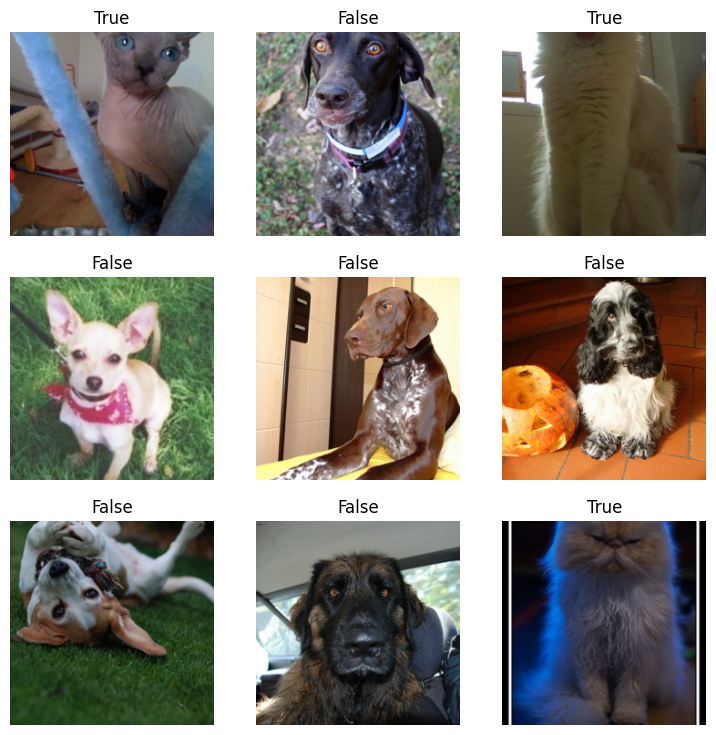

In [73]:
dls.show_batch()

### Then we can create a Learner, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [74]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.150827,0.030881,0.012179,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.055429,0.015831,0.006766,00:43


### If you want to make a prediction on a new image, you can use learn.predict:

In [75]:
learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 9.0086e-09]))

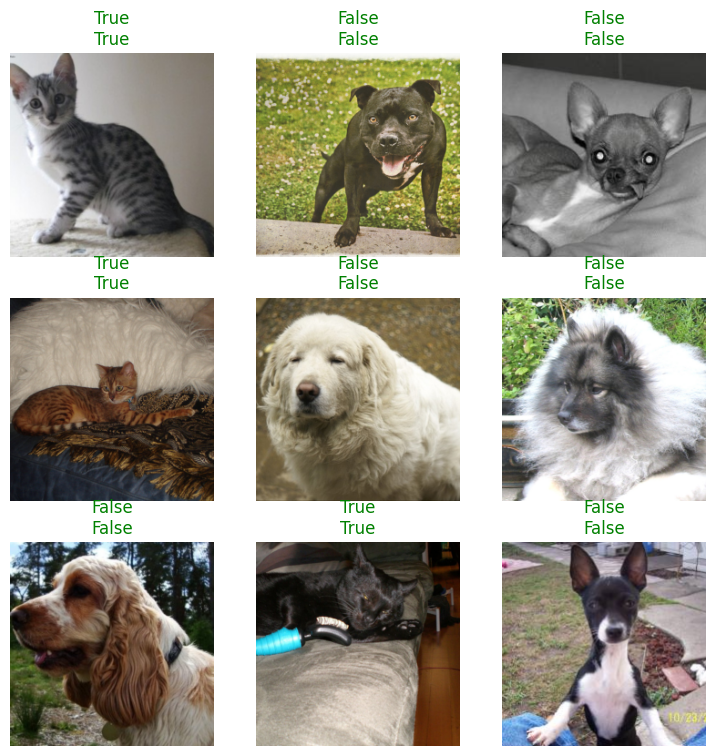

In [76]:
learn.show_results()

In [77]:
# to export the models
learn.export('model.pkl')

In [78]:
?vision_learner

## Which Image models are the best?
Pytorch has many [image models](https://timm.fast.ai/) around 500. These models are basically the mathemical functions differ on how much time, accuracy and from which family they belong.

Ross regularly [benchmarks](https://www.kaggle.com/code/jhoward/which-image-models-are-best/) new models as they are added to timm.

In [79]:
import timm

In [80]:
timm.list_models() # list all the models in pytorch

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit3_base_patch16_224',
 'beit3_giant_patch14_224',
 'beit3_giant_patch14_336',
 'beit3_large_patch16_224',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_sma

In [81]:
# we want to use the covnext model - Search for model architectures by Wildcard
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_atto_rms',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnext_zepto_rms',
 'convnext_zepto_rms_ols',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [82]:
??(vision_learner)


Object `(vision_learner)` not found.


Normally, models perform calculations using fp32 (Single-Precision), where each number takes up 32 bits of memory. By calling .to_fp16() on your vision_learner, you are telling the model to use Mixed Precision training.
$$
\begin{array}{|l|c|c|}
\hline
\textbf{Feature} & \textbf{FP32 (Standard)} & \textbf{FP16 (Mixed Precision)} \\ \hline
\text{Memory per value} & \text{4 Bytes (32 bits)} & \text{2 Bytes (16 bits)} \\ \hline
\text{Training Speed} & \text{Baseline} & \text{Significantly Faster} \\ \hline
\text{VRAM Usage} & \text{Higher} & \text{Lower (~50\% less)} \\ \hline
\text{Hardware Requirement} & \text{Any GPU} & \text{Modern GPU (Turing+)} \\ \hline
\end{array}
$$

In [83]:
# so if we want to use any of these models with fast-ai vision learner we have to provide it as a string as an input
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(1)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.075821,0.000653,0.000000,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.009658,0.000677,0.000000,00:49


### Understanding the `dls.vocab` Object

In fastai, the `dls.vocab` (Vocabulary) acts as the mapping system between human-readable labels and the integer indices used by the neural network.

$$
\begin{array}{|l|l|l|}
\hline
\textbf{Property/Method} & \textbf{Description} & \textbf{Example Output} \\ \hline
\text{dls.vocab} & \text{The list of unique class names} & \text{['black', 'grizzly', 'teddy']} \\ \hline
\text{len(dls.vocab)} & \text{Total number of classes (output neurons)} & \text{3} \\ \hline
\text{dls.vocab[i]} & \text{Find label string at index } i & \text{'grizzly' (for } i=1\text{)} \\ \hline
\text{dls.vocab.o2i} & \text{Dictionary mapping 'Object to Index'} & \text{\{'black': 0, 'grizzly': 1, ...\}} \\ \hline
\end{array}
$$

**Key Mathematical Concept:**
The final layer of your model outputs a vector $\mathbf{y}$ of size $N$, where $N = \text{len(dls.vocab)}$.
The probability for class $i$ is calculated such that:
$$ P(\text{class}_i) = \text{softmax}(\mathbf{y})_i $$
where the index $i$ corresponds exactly to the position in `dls.vocab`.

In [84]:
categories  =  learn.dls.vocab

In [85]:
print(categories) # since we have tewo categories false and true

[False, True]


In [86]:
# now to map them
def classify_img(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

In [87]:
classify_img(files[100])

{False: 2.967600598309354e-14, True: 1.0}

In [88]:
# Now if you want to look at the trianed model
model = learn.model

In [89]:
model

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (norm): Identity()
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (shortcut): Identity()
              (drop_path): Identity()
          

In [90]:
l = model.get_submodule('0.model.stem.1')

In [91]:
l

LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)

In [92]:
list(l.parameters())

[Parameter containing:
 tensor([ 1.2563e+00,  1.9189e+00,  1.2191e+00,  1.0391e+00, -7.5070e-04,
          7.6421e-01,  8.8847e-01,  1.6315e+00,  7.0599e-01,  3.2888e+00,
          7.8591e-01, -1.9629e-03,  1.0004e+00, -3.0209e-03,  3.2972e+00,
         -6.8269e-05,  1.9836e+00,  1.0216e+00,  4.4519e+00,  2.5502e-01,
          2.7248e+00,  9.2619e-01,  1.2371e+00,  3.6264e-03,  1.7867e+00,
          5.4353e-01,  4.6256e+00,  1.2091e-02,  3.6435e-04,  3.4489e+00,
          1.3509e+00,  4.1257e+00,  2.6875e+00,  4.1210e+00,  3.4001e+00,
          8.4969e-01,  7.3753e-01,  3.9796e+00,  1.2855e+00,  6.4097e-01,
          2.6895e+00,  1.1182e+00,  1.1710e+00,  5.5250e-01,  2.3338e+00,
          1.1135e-03,  9.6841e-01,  2.7576e-03,  1.1981e+00,  1.7889e+00,
          4.0058e-01,  4.5045e-01,  9.7225e-01,  3.9890e+00,  6.5761e-01,
          6.8796e-01,  9.8512e-01,  2.7072e+00,  1.2178e+00,  7.6235e-01,
          3.3019e+00,  1.6206e+00,  9.5542e-01,  2.1205e+00,  6.3041e-01,
          4.033

## How does really a neural networks work
A neural network is just a mathematical function. In the most standard kind of neural network, the function:

1.   Multiplies each input by a number of values. These values are known as parameters
2.   Adds them up for each group of values
3.  Replaces the negative numbers with zeros

This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using gradient descent. Let's see how this works...

In [93]:
from matplotlib.pyplot import title
# from ipywidgets import interact
from fastai.basics import *

# plotting a quadratic line
def plotting(f, color='r', min=-2,max=2, Title=None):
  x = torch.linspace(min, max, 500)[:,None]
  plt.plot(x, f(x), color)
  plt.title(Title)
  plt.show()



In [94]:
def f(x):
  return 3*x**2 + 2*x +1

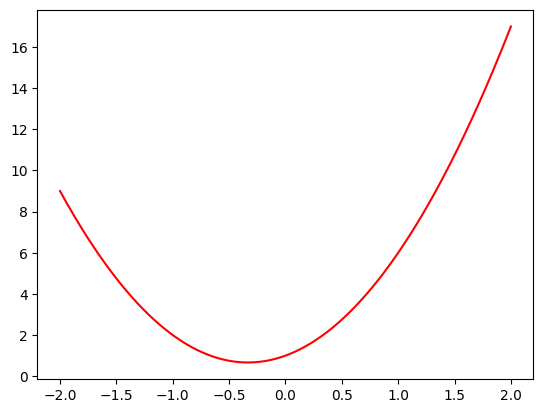

In [95]:
plotting(f,min=-2,max=2)

## This quadratic is of the form $ax^2 + bx + c$, with parameters $a=3$, $b=2$, $c=1$.

To make it easier to try out different quadratics for fitting a model to the data we'll create, let's create a function that calculates the value of a point on any quadratic:

In [96]:
def quad(a, b, c, x): return a*x**2 + b*x + c


## If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the partial function, like so:



In [97]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

## So for instance, we can recreate our previous quadratic:

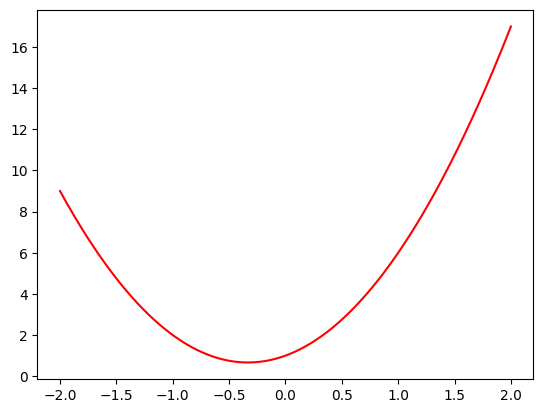

In [98]:
f2 = mk_quad(3,2,1)
plotting(f2)

Now let's simulate making some noisy measurements of our quadratic f. We'll then use gradient descent to see if we can recreate the original function from the data.

Here's a couple of functions to add some random noise to data:

In [99]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [100]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

/tmp/ipython-input-1958766108.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)


A link to numpy book [link](https://wesmckinney.com/book/)

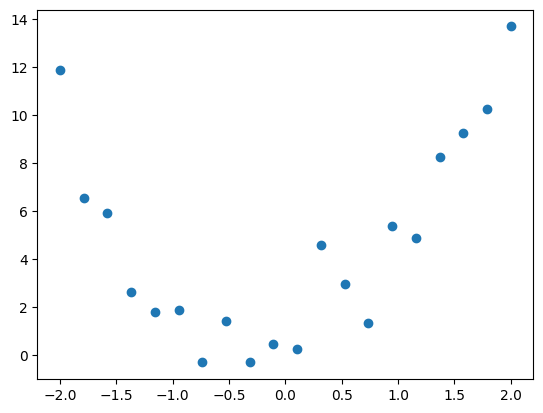

In [101]:
plt.scatter(x,y)

In [102]:
# @interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plotting(mk_quad(a,b,c))

In [103]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()


In [104]:
# @interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plotting(f,Title = (f'Loss: {loss:.2f}'))

Derivatives, which measure the rate of change of a function. Tutorial can be found [here](https://www.youtube.com/playlist?list=PLybg94GvOJ9ELZEe9s2NXTKr41Yedbw7M)